In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
Base = automap_base()

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station     = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
end_date = session.query(Measurement.date).order_by(Measurement.date.desc())[0][0]
print(end_date)


2017-08-23


In [11]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

q = session.query(Measurement).order_by(Measurement.date.desc()).first()
end_date_obj   = dt.datetime.strptime(q.date,'%Y-%m-%d')


In [14]:
# Calculate the date one year from the last date in data set.

start_date_obj = dt.datetime.strptime(str(end_date_obj - dt.timedelta(days=365)), '%Y-%m-%d %H:%M:%S').date()
print(start_date_obj)

2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date,
       Measurement.prcp]

q = session.query(*sel).filter(Measurement.date >= start_date_obj).all()

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column

filtered_df = pd.DataFrame(q)

filtered_df = filtered_df.rename(columns={0:"Measurement Date",
                                          1:"Precipitation"})

filtered_df.sort_values(by=["Measurement Date"],inplace=True)
filtered_df=filtered_df.set_index("Measurement Date")
filtered_df.head(5)

,Precipitation
Measurement Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


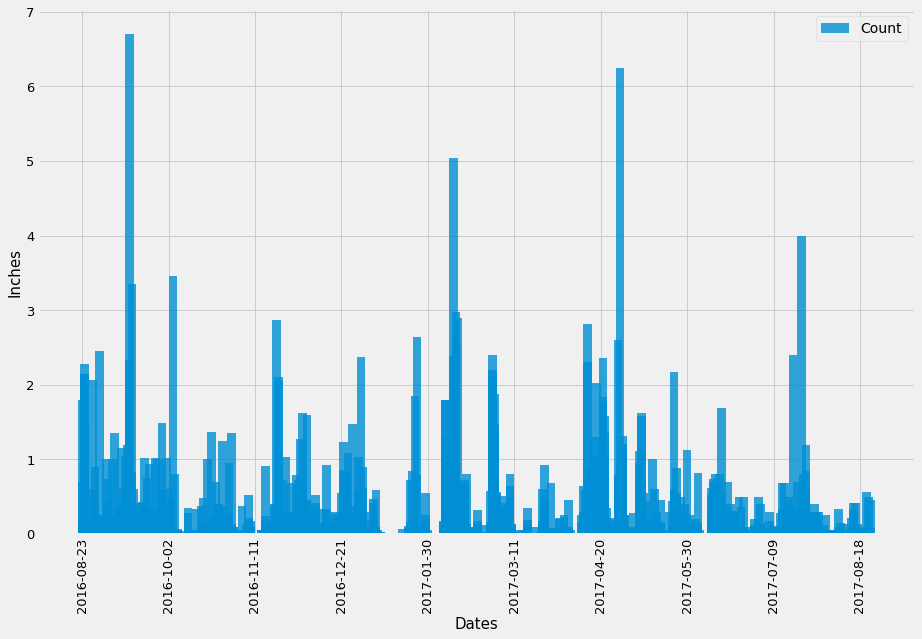

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
dates          = filtered_df.index.to_list()
precipitations = list(filtered_df["Precipitation"])

plt.subplots(figsize=(14, 9))
plt.bar(dates, precipitations, align='center',alpha=.8, label='Count',width=4)

plt.xlabel('Dates',fontsize = 15)
plt.ylabel('Inches', fontsize = 15)
plt.xticks(fontsize=13, rotation=45)

plt.legend()

majorticks = np.arange(0,380,40)
plt.xticks(majorticks,rotation=90,fontsize=13,)
plt.yticks(fontsize=13)
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
filtered_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset

station_count = len(session.query(Station.id).all())
print(station_count)

9


In [41]:
q =  session.query(Station).all()

for x in q:
    print(x.name)

WAIKIKI 717.2, HI US
KANEOHE 838.1, HI US
KUALOA RANCH HEADQUARTERS 886.9, HI US
PEARL CITY, HI US
UPPER WAHIAWA 874.3, HI US
WAIMANALO EXPERIMENTAL FARM, HI US
WAIHEE 837.5, HI US
HONOLULU OBSERVATORY 702.2, HI US
MANOA LYON ARBO 785.2, HI US


In [44]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

records = session.query(Station.id,Station.station,func.count(Station.id)).\
                  filter(Measurement.station == Station.station).\
                  group_by(Station.id,Station.name).\
                  order_by(func.count(Station.id).desc()).\
                  all()

for record in records:
    print(record)

(7, 'USC00519281', 2772)
(1, 'USC00519397', 2724)
(2, 'USC00513117', 2709)
(6, 'USC00519523', 2669)
(9, 'USC00516128', 2612)
(3, 'USC00514830', 2202)
(8, 'USC00511918', 1979)
(4, 'USC00517948', 1372)
(5, 'USC00518838', 511)


In [49]:
# Most active station id from the previous query, 
most_active_station = records[0][1]
print(most_active_station)


USC00519281


In [67]:
# Calculate the lowest, highest, and average temperature.

q = session.query(func.min(Measurement.tobs).label("lowest_temp"),
                  func.max(Measurement.tobs).label("highest_temp"),
                  func.avg(Measurement.tobs).label("avg_temp")).\
            filter(Measurement.station == most_active_station).first()

print(f"Data for most active station '{most_active_station}'")
print(f"Lowest temperature is {q.lowest_temp}")
print(f"Highest temperature is {q.highest_temp}")
print(f"Average temperature is {round(q.avg_temp,2)}")
      

Data for most active station 'USC00519281'
Lowest temperature is 54.0
Highest temperature is 85.0
Average temperature is 71.66


Text(0, 0.5, 'Frequency')

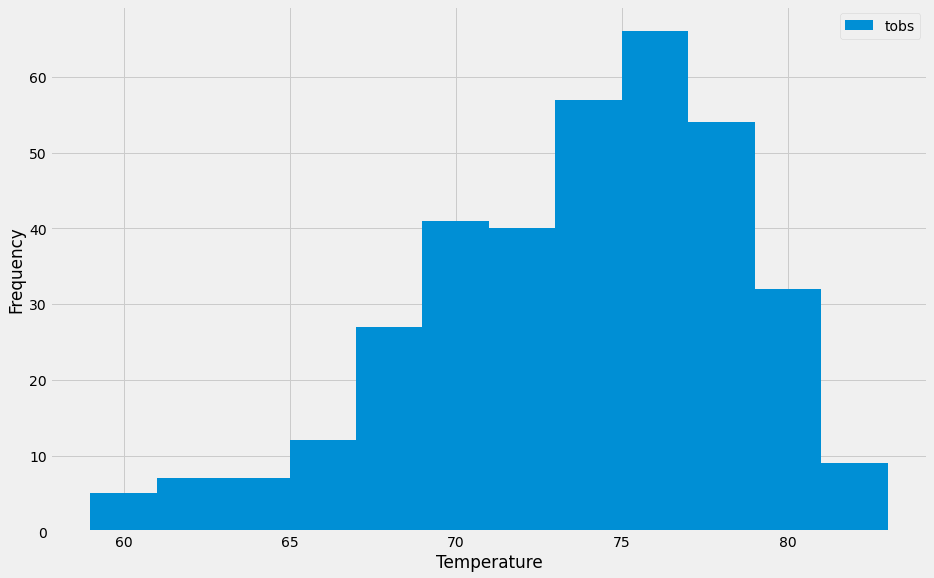

In [75]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

end_date = session.query(Measurement.date).\
                  filter(Measurement.station == Station.station).\
                  filter(Measurement.station == most_active_station).\
                  order_by(Measurement.date.desc()).\
                  first()

end_date_obj   = dt.datetime.strptime(end_date.date,'%Y-%m-%d')
start_date_obj = dt.datetime.strptime(str(end_date_obj - dt.timedelta(days=365)), '%Y-%m-%d %H:%M:%S').date()

records = session.query(Measurement.date,Measurement.tobs).\
                  filter(Measurement.station == Station.station).\
                  filter(Measurement.station == most_active_station).\
                  filter(Measurement.date >= start_date_obj).\
                  order_by(Measurement.date).\
                  all()

mst_actv_ws_df = pd.DataFrame(records)

mst_actv_ws_df = mst_actv_ws_df.rename(columns={0:"Measurement Date",
                                                1:"tobs"})

mst_actv_ws_df=mst_actv_ws_df.set_index("Measurement Date")

mst_actv_ws_df.plot(kind = "hist", bins = 12,figsize=(14,9))
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Close session

In [ ]:
# Close Session
session.close()